<a href="https://colab.research.google.com/gist/SrinehaS/e4954eff1b5f6ccb3a93741d20bac59f/dataanaylytics_modeling_final-1-1-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB MOVIE RATING PREDICTION AND CLASSIFICATION

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import statsmodels.api as sm

#for some statistics
from scipy import stats
from scipy.stats import norm, skew

from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import cross_val_score


import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.metrics import mean_squared_error,r2_score

In [0]:
#Read the excel
df_excel = pd.read_excel('imdb_may6.xlsx')
df_excel.head(5)

## Data Pre-processing

In [0]:
#Make a copy of df_excel to keep the original seperate
df = df_excel.copy()
#Delete unwanted columns
del df['primaryTitle']
del df['Production']
del df['Type']

#And drop null values.
df = df.dropna(how='any', axis=0)
df.reset_index(drop=True, inplace=True)

print(df.info())
print(df.describe())


In [0]:
#Expand genres into dummy columns
# Remove spaces from genre column to aid in dummy creation
df['genres'] = df['genres'].str.replace(' ', '')

genres = df['genres'].str.get_dummies(sep=',')
genres.reset_index(drop=True, inplace=True)
df = pd.concat([df, genres], axis=1)
del df['genres']


In [0]:
#To pre process 'Rated'
print(df['Rated'].value_counts())
#to drop'Not Rated','Unrated','NOT RATED'

df=df[~(df["Rated"].isin(['Not Rated','Unrated','NOT RATED']))]
print(df['Rated'].value_counts())

# Let's group some of the ratings together
def group_rating(rate):
    if rate in ["R", "PG", "PG-13", "G"]:
        return rate
    else:
        return "other"
    
df["Rated_clean"] = df["Rated"].map(group_rating)

rate_dummies = pd.get_dummies(df["Rated_clean"])
rate_dummies = rate_dummies.drop("other", axis=1)

#Expand Rated into dummy columns
#mpaa = df['Rated'].str.get_dummies()
rate_dummies.reset_index(inplace=True, drop=True)
df = pd.concat([df, rate_dummies], axis=1)
del df['Rated']
del df['Rated_clean']

In [0]:
#Create dummy column for languages
df['Language'] = df['Language'].str.replace(' ', '')
languages = df['Language'].str.get_dummies(sep=',')
#Check the values
print(languages.sum().sort_values(ascending = False).head(10))

#Pick the top 10 languages and add them back to the dataframe
languages = languages[['English', 'Spanish', 'French', 'German', 'Italian', 'Russian', 'Japanese','Mandarin','Arabic']]
df = pd.concat([df, languages], axis=1)
del df['Language']

In [0]:
#Create dummy column for directors
df['Director'] = df['Director'].str.replace(' ', '')
directors = df['Director'].str.get_dummies(sep=',')
#Check the values
#directors.sum().sort_values(ascending = False).head(30)

#Create dummy columns for directors and delete all who have fewer than 5 films.
directors = directors[directors.columns[directors.sum() >=5]]
df = pd.concat([df, directors], axis=1)
del df['Director']

In [0]:
df['Writers'] = df['Writers'].str.replace(' ', '')
writers= df['Writers'].str.get_dummies(sep=',')

#Check the values
#print(writers.sum().sort_values(ascending = False).head(35))
print(writers.sum().quantile(0.9))
#Create dummy columns for writers and delete all who have fewer than 4 films.
writers = writers[writers.columns[writers.sum() >=4]]
df = pd.concat([df, writers], axis=1)
del df['Writers']

In [0]:
#Create dummy column for countires
df['Country'] = df['Country'].str.replace(' ', '')
countries = df['Country'].str.get_dummies(sep=',')

print(countries.sum().sort_values(ascending = False).head(10))
print(countries.sum().quantile(0.9))

#Pick the top 10 countries and add them back to the dataframe
countries = countries[['USA', 'UK','France','Germany','Canada','Italy','Japan','Australia','Spain','China']]
df = pd.concat([df, countries], axis=1)
del df['Country']


In [0]:
#Based on Modeling 1, I am going to perform a log transform on my data to normalize

df['runtime'] = df['runtimeMinutes'].apply(lambda x: np.log(x))
df['votes'] = df['numVotes'].apply(lambda x: np.log(x))

In [0]:
#Reset index

df.reset_index(drop=True, inplace=True)

In [0]:
# df = df.loc[:,~df.columns.duplicated()]

In [0]:
film_df=df.copy()

#test_df = test_df.loc[:,~test_df.columns.duplicated()]
#Delete unwanted columns 
del film_df['isAdult']
del film_df['startYear']
del film_df['Actor']
del film_df['numVotes']
del film_df['runtimeMinutes']

### Data Correlation

In [0]:
# Checking correlation
film_df_corr = film_df.corr()
print (film_df_corr['averageRating'].sort_values(ascending=False)[:15], '\n')

averageRating    1.000000
votes            0.412256
runtime          0.389716
Drama            0.310141
Biography        0.178243
French           0.131698
History          0.116836
German           0.095572
UK               0.092519
France           0.089170
Italy            0.088620
Documentary      0.087193
War              0.081107
Animation        0.081030
Italian          0.079721
Name: averageRating, dtype: float64 



#### Clean dataset

In [0]:
#Cleaning the final dataset

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

film_df = clean_dataset(film_df)


 mu = 6.58 and sigma = 0.97



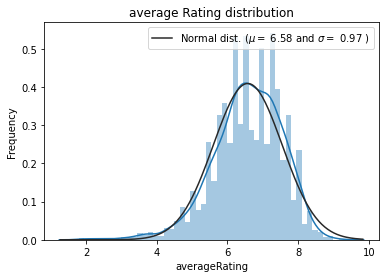

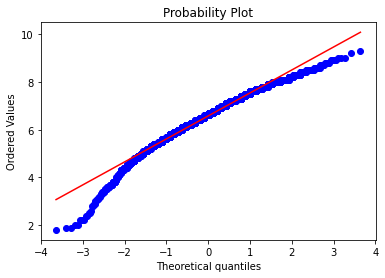

In [0]:

#Target variable for checking skewness

sns.distplot(film_df['averageRating'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(film_df['averageRating'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('average Rating distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(film_df['averageRating'], plot=plt)
plt.show()

### Diagnostics

In [0]:
#Scale data
scaler = MinMaxScaler()

data = film_df.drop('averageRating', axis=1)
target = film_df['averageRating']

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)



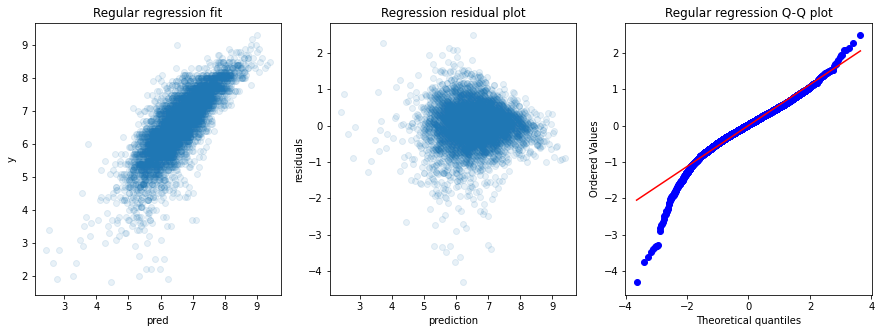

In [0]:
#Diagnostic plots
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");


###  DATA MODELLING 

In [0]:
#modelling

moviesR = film_df.copy() #lets keep our original movies for reference. Here moviesR is for Regression model
moviesC = film_df.copy() #Here moviesC is for classification model

#### TRAIN TEST SPLIT AND MIN MAX SCALING

train_test_split() returns four objects:

1. X_train is the subset of our features used for training.
2. X_test is the subset which will be our 'hold-out' set - what we'll use to test the model.
3. y_train is the target variable averageRating which corresponds to X_train.
4. y_test is the target variable averageRating which corresponds to X_test.

fit the model using X_train and y_train, and we'll score with X_test and y_test. The model.fit() method will fit the  regression models on the features and target variable that we pass.

In [0]:
#Datasets copied
y = moviesR.pop('averageRating')
X = moviesR
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Scaling data

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns, index = X_test.index)

(4078, 1095)
(4078,)
(1020, 1095)
(1020,)


### Linear Regression

In [0]:
#Initialize the model# 
# Linear Regression

lr = LinearRegression()
model = lr.fit(X_train, y_train)

accuracies = cross_val_score(estimator=lr, X=X_train, y=y_train, cv=10) #cross-validation
print(accuracies.mean())
print ("R^2 is: \n", model.score(X_test, y_test))

-2.0044286178418843e+24
R^2 is: 
 -1.7228457200891692e+23


In [0]:
#Simple Linear Regression
# Adding a constant variable for using the stats model

X_train_rfe_constant = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_rfe_constant).fit()   # Running the linear model

#Let's see the summary of our linear model
print(lm.summary())

X_test_rfe = X_test
X_test_rfe_constant = sm.add_constant(X_test)

y_pred_linear = lm.predict(X_test_rfe_constant)
y_pred_linear.values
y_pred_linear.min(), y_pred_linear.max()

#mean square error
mean_squared_error(y_pred_linear, y_test)


                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     6.136
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        23:39:49   Log-Likelihood:                -3420.5
No. Observations:                4078   AIC:                             8853.
Df Residuals:                    3072   BIC:                         1.520e+04
Df Model:                        1005                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

0.6396282129151393

### SVM

In [0]:
#SVM
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', gamma=0.1)
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=3)

#SVM with RBF
svr_rbf.fit(X_train, y_train)
y_pred_svm_rbf = svr_rbf.predict(X_test)

y_pred_svm_rbf
y_pred_svm_rbf.min(), y_pred_svm_rbf.max()
mean_squared_error(y_pred_svm_rbf, y_test)

0.45085293035767005

In [0]:
#SVM linear
svr_lin.fit(X_train, y_train)
y_pred_svm_lin = svr_lin.predict(X_test)
mean_squared_error(y_pred_svm_lin, y_test)

0.5168707180699302

In [0]:
#SVM_poly
svr_poly.fit(X_train, y_train)
y_pred_svm_poly = svr_poly.predict(X_test)
mean_squared_error(y_pred_svm_poly, y_test)

0.9734303972143566

#### GRADIENT BOOSTING REGRESSOR 

In [0]:
#ensemble models
#Gradient Boosting with Hyper Parameter Tuning

n_trees=100
gradientboost = ensemble.GradientBoostingRegressor(loss='ls',learning_rate=0.04,n_estimators=n_trees,max_depth=4)
gradientboost.fit(X_train,y_train)

y_pred_gb=gradientboost.predict(X_test)
error=gradientboost.loss_(y_test,y_pred_gb) ##Loss function== Mean square error
print("MSE:%.3f" % error)
print("GBR Train Accuracy:",gradientboost.score(X_train, y_train))
print("GBR Test Accuracy:",gradientboost.score(X_test, y_test))

MSE:0.497
GBR Train Accuracy: 0.5414352881569651
GBR Test Accuracy: 0.4879777844234525


### Random Forest Regressor

In [0]:
#RANDOM FOREST REGRESSOR

RF=RandomForestRegressor(n_estimators=100)
model=RF.fit(X_train,y_train)
print ("R^2 for test is: \n", model.score(X_test, y_test))


predictions = model.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, predictions))


print("Random Forest Train Accuracy:",model.score(X_train, y_train))
print("Random Forest Test Accuracy:",model.score(X_test, y_test))


R^2 for test is: 
 0.529436861253979
RMSE is: 
 0.4571779196078433
Random Forest Train Accuracy: 0.930504347216442
Random Forest Test Accuracy: 0.529436861253979


In [0]:
# Calculate the feature ranking - Top 10 
importances = RF.feature_importances_ 
indices = np.argsort(importances)[::-1] 

print("Top 10 Important Features\n")

for f in range(10): 
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Top 10 Important Features

1. votes (0.278122)
2. runtime (0.143575)
3. Drama (0.098339)
4. USA (0.037806)
5. Action (0.021644)
6. Documentary (0.017309)
7. Comedy (0.010776)
8. UweBoll (0.010469)
9. Horror (0.010456)
10. Adventure (0.009994)


In [0]:
d={'predictions':predictions,
   'actual':y_test}
data_predicted_actual=pd.DataFrame(d)

data_predicted_actual

,predictions,actual
1209,6.944,7.4
1512,6.922,6.8
1057,6.745,7.5
3713,5.979,5.7
157,5.967,7.4
...,...,...
1177,7.104,7.9
1316,6.253,7.0
5568,7.113,7.1
2166,6.533,5.8


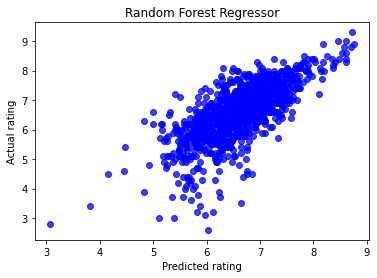

In [0]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted rating')
plt.ylabel('Actual rating')
plt.title('Random Forest Regressor')
plt.show()

In [0]:
data = [['Linear regression', 0.67], ['RBF_SVM', 0.44],['SVM_linear',0.52],['SVM_poly',0.97],['GBR',0.49],['Random Forest',0.47]] 
MSE_table = pd.DataFrame(data, columns = ['Model', 'mse']) 

MSE_table

,Model,mse
0,Linear regression,0.67
1,RBF_SVM,0.44
2,SVM_linear,0.52
3,SVM_poly,0.97
4,GBR,0.49
5,Random Forest,0.47


### XGBoosting Regressor

In [0]:
df_xgb=film_df.copy()

df_xgb = df_xgb.loc[:,~df_xgb.columns.duplicated()]

#Datasets copied
y = df_xgb.pop('averageRating')
X = df_xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Scaling data

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns, index = X_test.index)

(4078, 1095)
(4078,)
(1020, 1095)
(1020,)


In [0]:
from sklearn.metrics import explained_variance_score
gbm = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100, learning_rate=0.08, 
                       gamma=0, subsample=0.75,colsample_bytree=1, 
                       max_depth=7).fit(X_train, y_train)

predictions = gbm.predict(X_test)
print(explained_variance_score(predictions,y_test))

print("XGBOOST Train Accuracy:",gbm.score(X_train, y_train))
print("XGBOOST Test Accuracy:",gbm.score(X_test, y_test))


0.022632692161196677
XGBOOST Train Accuracy: 0.7176647451066127
XGBOOST Test Accuracy: 0.559121485609297


### Classification model 

In [0]:
#Building a Classification Model
# 1-3 -> Flop Movie
# 3-6 -> Average Movie
# above 6 -> Hit Movie


y_train_classification = y_train.copy()
y_train_classification = pd.cut(y_train_classification, bins=[1, 3, 6, float('Inf')], labels=['Flop Movie', 'Average Movie', 'Hit Movie'])

y_test_classification = y_test.copy()
y_test_classification = pd.cut(y_test_classification, bins=[1, 3, 6, float('Inf')], labels=['Flop Movie', 'Average Movie', 'Hit Movie'])


X_train_classification = X_train.copy()
X_test_classification = X_test.copy()

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(solver = 'saga', random_state = 0)
logit_model.fit(X_train_classification, y_train_classification)

y_logit_pred = logit_model.predict(X_test_classification)

from sklearn import metrics
count_misclassified = (y_test_classification != y_logit_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test_classification, y_logit_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test_classification, y_logit_pred, average= 'macro')
print('Precision: {:.2f}'.format(precision))
recall = metrics.recall_score(y_test_classification, y_logit_pred, average= 'macro')
print('Recall: {:.2f}'.format(recall))
f1_score = metrics.f1_score(y_test_classification, y_logit_pred, average = 'macro')
print('F1 score: {:.2f}'.format(f1_score))

Misclassified samples: 207
Accuracy: 0.80
Precision: 0.83
Recall: 0.56
F1 score: 0.62


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
#Support Vector Classifier with Linear, Polynomial, RBF

from sklearn.svm import SVC
svc_linear_model = SVC(kernel='linear', C=100, gamma= 'scale', decision_function_shape='ovo', random_state = 42)

svc_linear_model.fit(X_train_classification, y_train_classification)

y_svc_linear_pred = svc_linear_model.predict(X_test_classification)

from sklearn import metrics
count_misclassified = (y_test_classification != y_svc_linear_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test_classification, y_svc_linear_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test_classification, y_svc_linear_pred, average= 'macro')
print('Precision: {:.2f}'.format(precision))
recall = metrics.recall_score(y_test_classification, y_svc_linear_pred, average= 'macro')
print('Recall: {:.2f}'.format(recall))
f1_score = metrics.f1_score(y_test_classification, y_svc_linear_pred, average = 'macro')
print('F1 score: {:.2f}'.format(f1_score))

Misclassified samples: 228
Accuracy: 0.78
Precision: 0.53
Recall: 0.55
F1 score: 0.54


In [0]:
from sklearn.svm import SVC
svc_poly_model = SVC(kernel='poly', C=100, gamma= 'scale', degree = 3, decision_function_shape='ovo', random_state = 42)

svc_poly_model.fit(X_train_classification, y_train_classification)
y_svc_poly_pred = svc_poly_model.predict(X_test_classification)

from sklearn import metrics
count_misclassified = (y_test_classification != y_svc_poly_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test_classification, y_svc_poly_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test_classification, y_svc_poly_pred, average= 'macro')
print('Precision: {:.2f}'.format(precision))
recall = metrics.recall_score(y_test_classification, y_svc_poly_pred, average= 'macro')
print('Recall: {:.2f}'.format(recall))
f1_score = metrics.f1_score(y_test_classification, y_svc_poly_pred, average = 'macro')
print('F1 score: {:.2f}'.format(f1_score))

Misclassified samples: 243
Accuracy: 0.76
Precision: 0.55
Recall: 0.54
F1 score: 0.55


In [0]:
#Ensemble Models
#Random Forest Classifier with Hyper Parameter tuning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90,100],#list(range(90,100)),
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 500, 1000],
    'random_state' :[0]
}
# Create a based model
rf_model_classification = RandomForestClassifier()
# Instantiate the grid search model
grid_search_rf_model_classificaiton = GridSearchCV(estimator = rf_model_classification, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_rf_model_classificaiton.fit(X_train_classification, y_train_classification)

y_rf_classification_pred = grid_search_rf_model_classificaiton.predict(X_test_classification)

from sklearn import metrics
count_misclassified = (y_test_classification != y_rf_classification_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test_classification, y_rf_classification_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test_classification, y_rf_classification_pred, average= 'macro')
print('Precision: {:.2f}'.format(precision))
recall = metrics.recall_score(y_test_classification, y_rf_classification_pred, average= 'macro')
print('Recall: {:.2f}'.format(recall))
f1_score = metrics.f1_score(y_test_classification, y_rf_classification_pred, average = 'macro')
print('F1 score: {:.2f}'.format(f1_score))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.9min finished


Misclassified samples: 278
Accuracy: 0.73
Precision: 0.24
Recall: 0.33
F1 score: 0.28


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#Gradient Boost Classifier with Hyper Parameter Tuning

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 50, 90],
    'max_features': [3],
    'min_samples_leaf': [3],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 500],
    'learning_rate' : [0.01, 0.2],
    'random_state' : [0]
}
# Create a based model
gbc_model_classification = GradientBoostingClassifier()
# Instantiate the grid search model

grid_search_gbc_model_classificaiton = GridSearchCV(estimator = gbc_model_classification, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

grid_search_gbc_model_classificaiton.fit(X_train_classification, y_train_classification)
y_gbc_model_pred = grid_search_gbc_model_classificaiton.predict(X_test_classification)

from sklearn import metrics
count_misclassified = (y_test_classification != y_gbc_model_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test_classification, y_gbc_model_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test_classification, y_gbc_model_pred, average= 'macro')
print('Precision: {:.2f}'.format(precision))
recall = metrics.recall_score(y_test_classification, y_gbc_model_pred, average= 'macro')
print('Recall: {:.2f}'.format(recall))
f1_score = metrics.f1_score(y_test_classification, y_gbc_model_pred, average = 'macro')
print('F1 score: {:.2f}'.format(f1_score))
                              

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.0min finished


Misclassified samples: 222
Accuracy: 0.78
Precision: 0.65
Recall: 0.55
F1 score: 0.59
